# Final Degree Project- Model Agnostic Methods for Stroke Prediction. 
By Gabriela Gutiérrez-Colomer mentored by Dr. Felipe Alonso Atienza

The database we are going to deal with contains information on **5110 patients**, some of whom have suffered a stroke and some of whom have not. The aim is to analyse the predictions in order to obtain information about the variables and thus be able to interpret the model. 

The questions we must ask ourselves are: **Why has the model classified in this way?** **What is the basis for distinguishing between one class and another?** **Would the prediction change if some variable is also changed?** 

In [1]:
#import all packages 
from sklearn import model_selection   
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

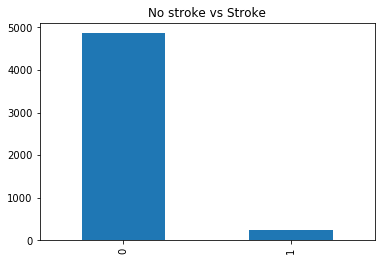

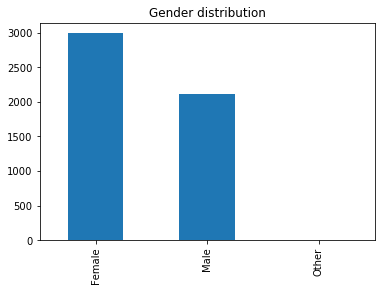

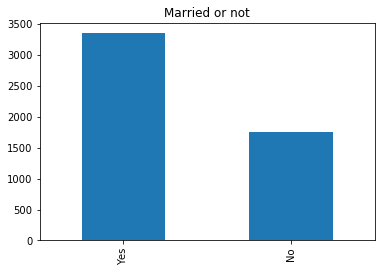

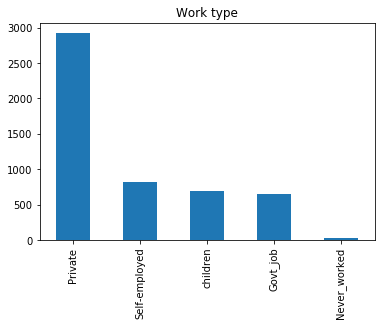

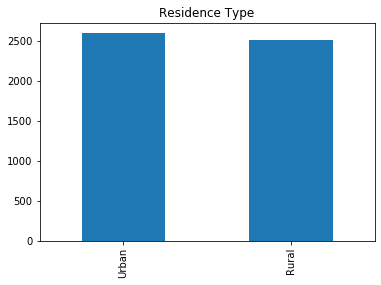

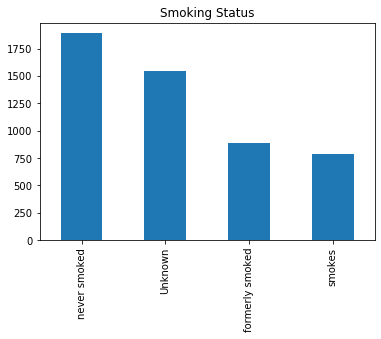

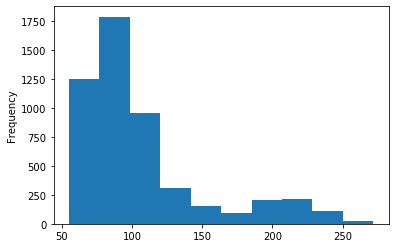

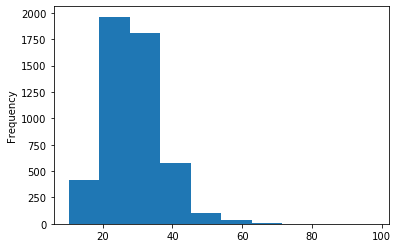

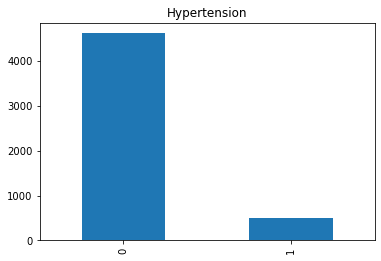

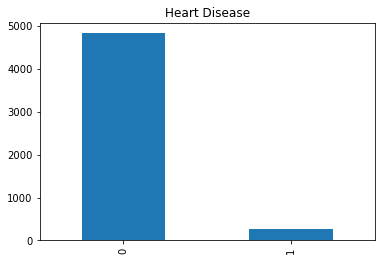

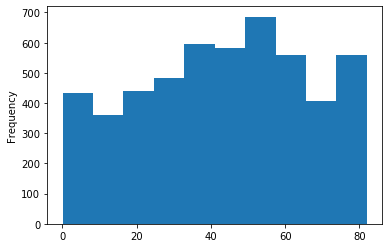

In [2]:
%run Stroke_Data_Treatment.ipynb
#run the script with the data treatment

## 1. Train the Model- Prediction of Stroke Patients 
We will train a basic decision tree model in order to develop the methods for interpretability. 

In [3]:
# split into input (X) and output (y) variables
X= data.drop(['stroke'], axis = 1)
y= data['stroke']

In [4]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [5]:
feature_names = X_res.columns

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(X_train, y_train)

## 2. Global Model Agnostic Methods 
### a. Permutation Importance
Permutation importance is not an interpretable direct method because it is not a model itself but rather a way of explaining how a model behaves through feature importance. A feature is considered important when, changing the order of the values and performing some prediction, the predictions become a mess (the error of the model increases). With this method, we can understand what is the model using when deciding, for example, if a patient is considered to have a stroke or not.

In [7]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(tree_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.2126 ± 0.0081,age
0.0711 ± 0.0091,gender_Female
0.0434 ± 0.0057,work_type_Private
0.0377 ± 0.0061,work_type_Govt_job
0.0240 ± 0.0031,work_type_Self-employed
0.0231 ± 0.0017,gender_Male
0.0043 ± 0.0022,ever_married
0.0042 ± 0.0009,heart_disease
0.0008 ± 0.0012,avg_glucose_level
0 ± 0.0000,Residence_type_Rural


Te most improtant features are `age` and `gender_Female` according to permutation importance. 

If we interpret this, we could understan that for the model to classify a patient as having a stroke, when deciding where to "put" the patient, the model will rely highly on the age of the patient. If we had a little intuition we could conclude that the really important variable is in fact `age`. `age` is so important because if the values of it are shuffled, the error of the model will increase by a 20%. 

We have to further study the variable age to see if it can give us some more information. 

### b. Partial Dependence Plots 
Feature importance shows what variables are the most important or which are the varaibles that the model relies on the most, partial dependance plots show how variables affect predictions and also wether the relationship is linear, monotonic or more complex. Partial Dependance Plot (PDP) is a very sophisticated method.
The function for partial dependence for regression is: 

$$\hat{f}_{s}(x_{S})= E_{X_{C}}[\hat{f}(x_{S}, X_{C})]= \int \hat{f}(x_{S}, X_{C})d \mathbb{P}(X_{c})$$

Partial dependence works by marginalizing the machine learning model output over the distribution of the features in set C (marginalising the variables that we are not going to use for the partial plot), so that the function shows the relationship between the features in set S we are interested in and the predicted outcome.


#### Age of Patient- Partial Dependence Plot
How does the age of the patient affect predictions? Is it more probable to have a stroke with a certain age? 

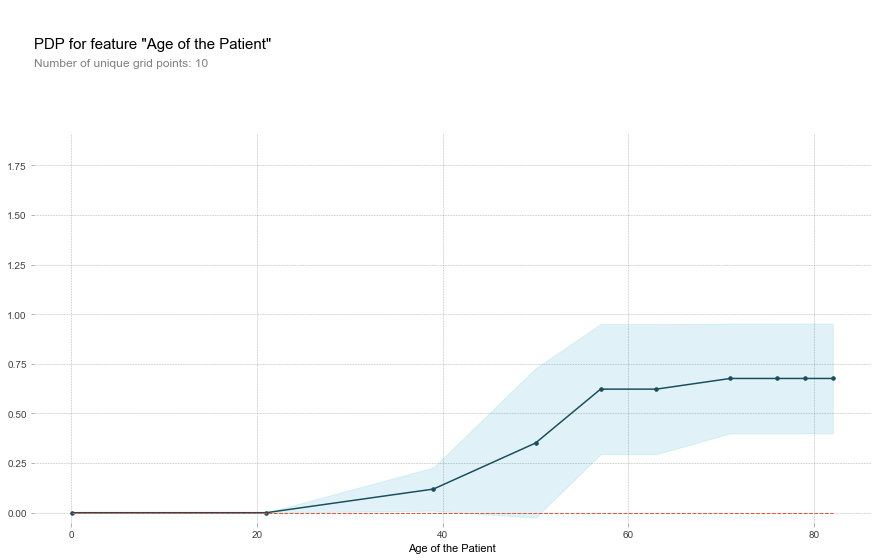

In [8]:
import matplotlib.pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_age = pdp.pdp_isolate(model=tree_model, dataset=X_test, model_features=feature_names, feature='age')

# plot it
pdp.pdp_plot(pdp_age, 'Age of the Patient')
plt.show()

#### Interpreting results for Patient Age in Stroke prediction
As we can see in the graph, from 0 to 21 years old, being younger or older is not goint to increase neither decrease the probability of having a stroke. 

From 21 years old, the chances of getting a stroke as the age increases are higher. 
From 40 years old the probability of having a stroke increases quite a lot and it keeps growing until it reaches more or less 56 years old, at 56 it keeps steady until 63 years old, where the probability of having a stroke potentially increases.  

In conclusion the crucial stroke-age is in between 56 and 75 years old, where the chances of getting a stroke really get significant. This information could be very interesting for the doctors because they could install a strict follow up in between those ages to try to prevent as much as possible strokes.  

## 3. Local Model Agnostic Methods
### a. SHAP values 
In this script, we will treat specifically TreeSHAP, TreeSHAP are SHAP values used for decision trees, random forests and gradient boosting. TreeSHAP defines the value function using the conditional expectation  $E_{X_{S}|{X_{C}}}(\hat{f}(x) | x_{S})$. 

Each feature value is a force that either increases or decreases the prediction. The prediction starts from the baseline. The baseline for Shapley values is the average of all predictions. In the plot, each Shapley value is an arrow that pushes to increase (positive value) or decrease (negative value) the prediction. These forces balance each other out at the actual prediction of the data instance.

#### Patient 1- Analysing SHAP values 
What are the variables that made the model decide wether this patient has a stroke or not? 

In [9]:
row_to_show = 23
data_for_prediction = X_test.iloc[row_to_show]  
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
tree_model.predict_proba(data_for_prediction_array)

array([[0.39429929, 0.60570071]])

In [10]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(tree_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [12]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

The variables that make the model attribute quite a high probability of stroke are age, this patient is 78 years old; as we discussed in the PDP, from 73 onwards the probability of having a stroke was higher than with other ages. The variable age is veri decise to the classifier.

In [13]:
row_to_show = 25
data_for_prediction = X_test.iloc[row_to_show]  
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
tree_model.predict_proba(data_for_prediction_array)

array([[0.97979798, 0.02020202]])

In [15]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(tree_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [16]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

#### Patient 1- Analysing SHAP values 
The second patient, who is very unlikely to suffer a stroke due to his young age. The classifier understands that a 5-year-old child, due to his or her young age, could not suffer a stroke, the probability would be negligible.

## 4. Conclusions 
We can conclude that age is the decisive variable when classifying a patient. The model understands that an excessively young patient, as would be patient number two, because of his young age, could not suffer a stroke; however, patients with advanced age, specifically age above 54, can be classified as patients with the possibility of stroke. 
The model does not only use the age variable to decide since not all patients who are 74 years old (for example) have suffered a stroke, but it is the most important variable when making the decision. 

Age seems to be the most important variable for the model and this is undeniable. 
To know whether age really has a causal relationship with stroke, a causal study should be performed and the Average Treatment Effect estimated. 
It is possible that another variable is really behind the likelihood of stroke, however, since the database does not reflect it, age will be the decisive variable. 

In [19]:
import xgboost
import shap

# train XGBoost model
model = xgboost.XGBClassifier().fit(X, y)

# compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

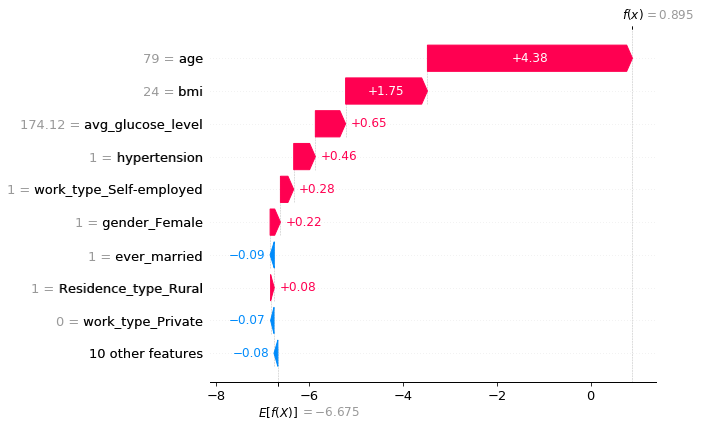

In [20]:
fig = shap.plots.waterfall(shap_values[4])